# 2024 WATER summer school

This material is intended for the use in 2024 WATER summer school.

Created by: Zhi Li

Date: 2024-06-28

In [ ]:
# Download geo-processed data for the work
%%capture
!git clone https://github.com/chrimerss/2024SummerSchool

In [ ]:
# install some Python packages
%%capture
!pip install zarr
!pip install xarray[complete]
!pip install cartopy
!pip install rioxarray
!pip install ctime

In [ ]:
# import necessary python packages
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rioxarray
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# import proplot as pplt

# Preprocess data

Now we can explore a bit on the data we acquired from satellite, radar, and rain gauges. The first thing bear in mind is to see if you have some system differences comparing one another.

Let's load the data and show some maps.

In [ ]:
date_range= pd.date_range('2017-08-25', '2017-09-02', freq='h')
# load NCEP data
ds_ncep= xr.concat([xr.open_dataset(dt.strftime('2024SummerSchool/NCEP/ST2gg%Y%m%d%H.tif')) for dt in date_range],
                   dim=xr.Variable('time', date_range))['band_data'].squeeze().load()
#load MRMS data
ds_mrms= xr.concat([xr.open_dataset(dt.strftime('2024SummerSchool/MRMS/GaugeCorr_QPE_01H_00.00_%Y%m%d-%H0000.tif')) \
                    for dt in date_range], dim=xr.Variable('time', date_range))['band_data'].squeeze().load()

#load IMERG data
ds_imerg= xr.open_mfdataset('2024SummerSchool/IMERG/3B-HHR-E.MS.MRG.*.nc4').resample(time='1H').mean().\
                                                            sel(time=slice('2017-08-25', '2017-09-02 00:00:00'))['precipitation'].load()


In [ ]:
# make some rainfall color maps for later use.

nws_precip_colors = [
    "#04e9e7",
    "#019ff4",
    "#0300f4",
    "#02fd02",
    "#01c501",
    "#008e00",
    "#fdf802",
    "#e5bc00",
    "#fd9500",
    "#fd0000",
    "#d40000",
    "#bc0000",
    "#f800fd",
    "#9854c6",
]
precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)
norm= matplotlib.colors.Normalize(vmin=0.1, vmax=1000)

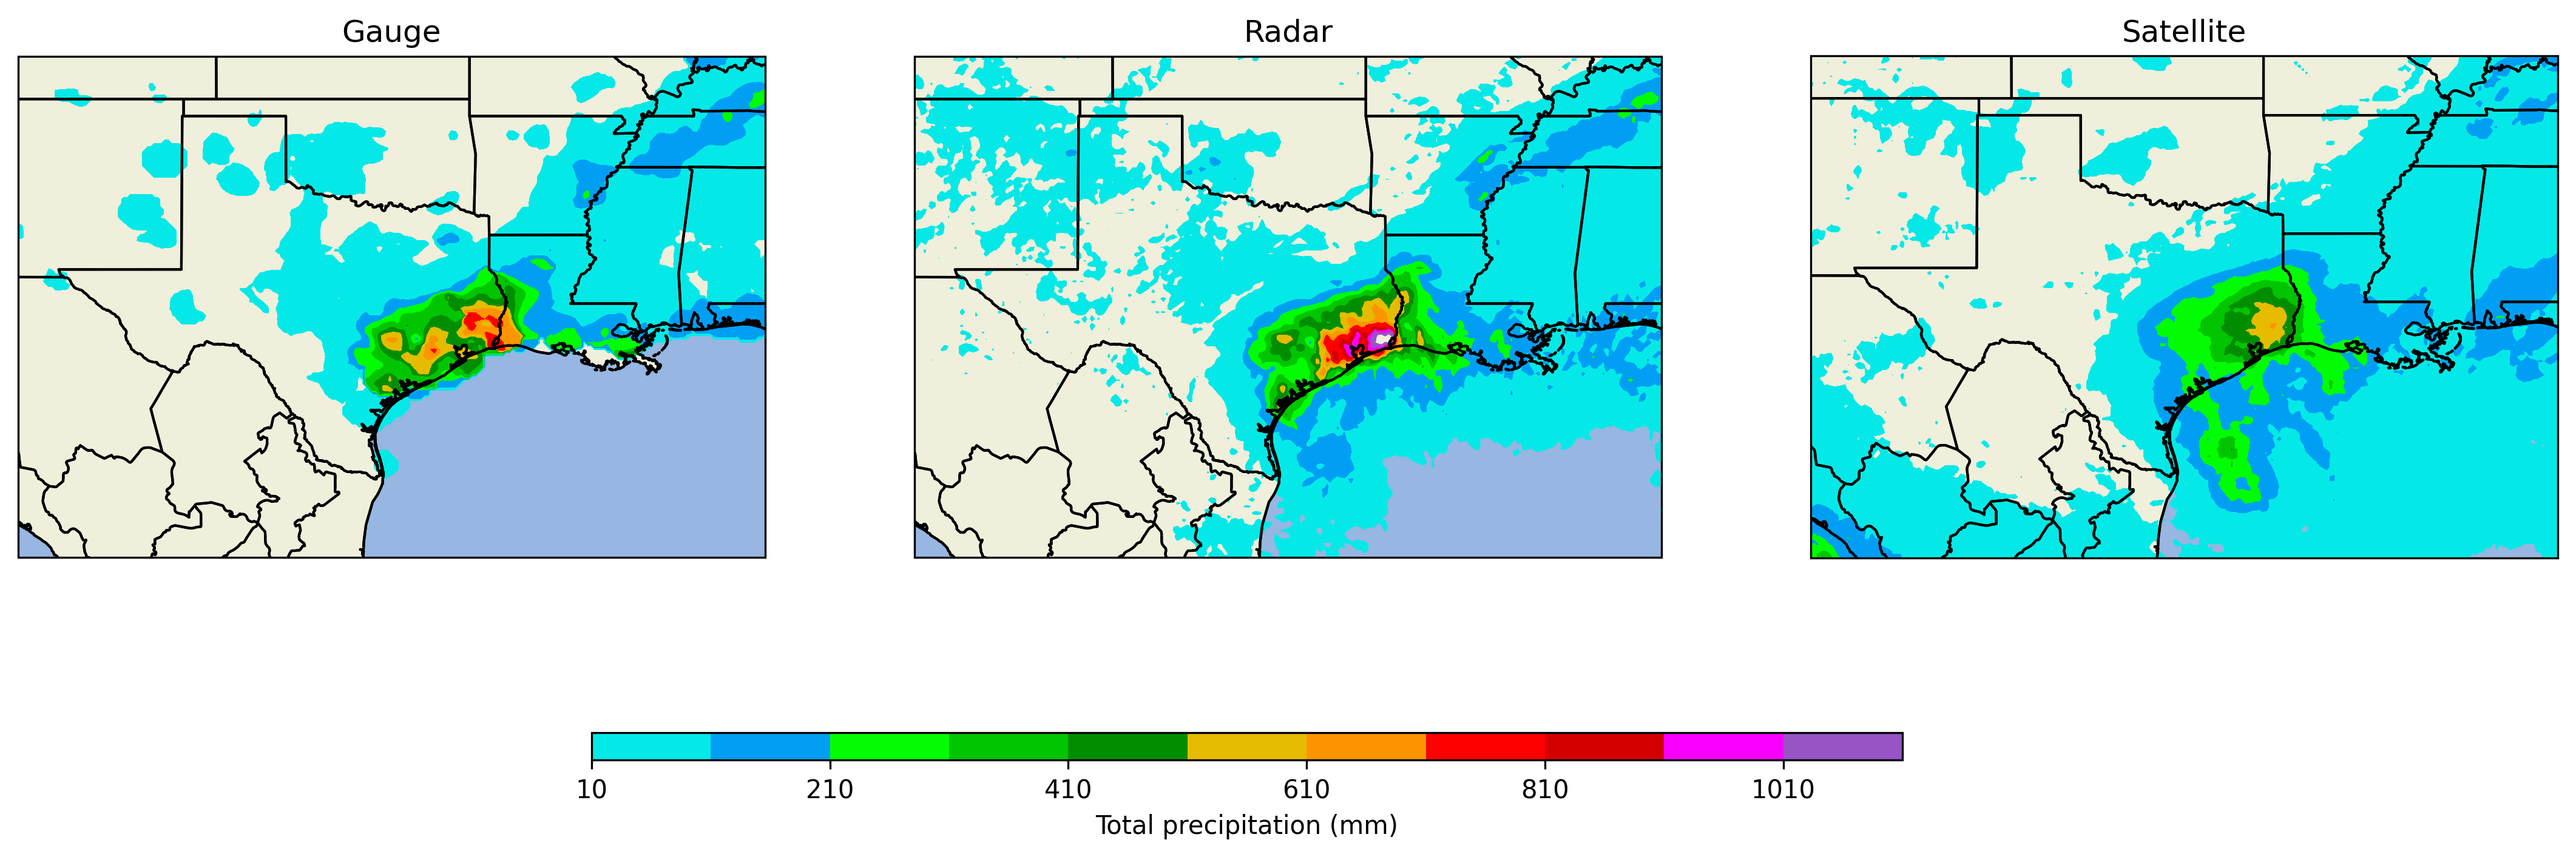

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6), dpi=300,
                         subplot_kw={'projection': ccrs.PlateCarree()}, facecolor='white')
ax= axes[0]
# plot NCEP gauge
im = ax.contourf(ds_ncep.x, ds_ncep.y, ds_ncep.sum(dim='time').squeeze(),
                 cmap=precip_colormap, levels=np.arange(10, 1200, 100))
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.STATES)
ax.set_title('Gauge')

ax= axes[1]
# plot MRMS radar
im = ax.contourf(ds_mrms.x, ds_mrms.y, ds_mrms.sum(dim='time').squeeze(),
                 cmap=precip_colormap, levels=np.arange(10, 1200, 100))
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.STATES)
ax.set_title('Radar')

ax= axes[2]
# plot IMERG satellite
im = ax.contourf(ds_imerg.lon, ds_imerg.lat, ds_imerg.sum(dim='time').squeeze().T,
                 cmap=precip_colormap, levels=np.arange(10, 1200, 100))
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.STATES)
ax.set_title('Satellite')

# fig.subplots_adjust(bottom=0.15)
cbar_ax = fig.add_axes([0.3, 0.08, 0.4, 0.025])
cb = fig.colorbar(im, cax=cbar_ax, orientation='horizontal')
cb.set_label('Total precipitation (mm)')

plt.show();

# Triple Collocation

We've talked about the foundations for Triple Collocation method, so now we can implement it in python.

Since each pixel has a time series, we can iteratively calculate Triple error (RMSE) and triple correlation (CC) for each pixel and inspect its error distribution over space.

In [ ]:
def bootstrap_resample(X, n=None):
    """ Bootstrap resample an array_like
    Parameters
    ----------
    X : pandas data frame
        data to resample
    n : int, optional
        length of resampled array, equal to len(X) if n==None
    Results
    -------
    returns X_resamples
    """
    if n == None:
        n = len(X)

    resample_i = np.floor(np.random.rand(n)*len(X)).astype(int)
    X_resample = X.iloc[resample_i, :]

    return X_resample

def mtc(X):
    '''
    Args:
    --------------------
    X: reshaped input data (time, product)

    Returns:
    --------------------
    rmse: triple error RMSE for each product
    cc: triple correlation CC for each product
    '''
    # X= X.dropna()
    # # print(X)
    # for col in X.columns:
    #     X= X[X[col]>=0.01]
    #     X.clip(lower=0, inplace=True)
    # # print(X)
    # X= X.apply(np.log)

    N_boot= 100
    rmse= np.zeros((N_boot,3))
    cc= np.zeros((N_boot, 3))
    for i in range(N_boot):
        sigma= np.zeros(3)
        r= np.zeros(3)
        sample= bootstrap_resample(X, n=N_boot)

        cov= sample.cov().to_numpy()
        # compute RMSE
        if (cov==0).any().any():
            rmse[i,:]=np.nan
            cc[i,:]= np.nan
        else:
            sigma[0]= cov[0,0] - (cov[0,1]*cov[0,2])/(cov[1,2])
            sigma[1]= cov[1,1] - (cov[0,1]*cov[1,2])/(cov[0,2])
            sigma[2]= cov[2,2] - (cov[0,2]*cov[1,2])/(cov[0,1])
            # print(cov[0,0], cov[1,1], cov[2,2])

            sigma[sigma<0]= np.nan
            sigma= sigma**.5

            #compute correlation coefficient
            r[0] = (cov[0,1]*cov[0,2])/(cov[0,0]*cov[1,2])
            r[1] = (cov[0,1]*cov[1,2])/(cov[1,1]*cov[0,2]);
            r[2] = (cov[0,2]*cov[1,2])/(cov[2,2]*cov[0,1]);

            r[r<0] = 0.0001
            r[r>1] = 1
            r= r**.5
            r[r<1e-3] = 0

            rmse[i,:]= sigma
            cc[i, :]= r

    return np.nanmean(rmse, axis=0), np.nanmean(cc,axis=0)

In [ ]:
# now prepare the data, I only wanted to calculate pixels with heavy rain
threshold= 50 # my threshold is 10 mm over one week, I am using MRMS as my reference (you can choose others as well)
ds_mrms= ds_mrms.where(ds_mrms.sum(dim='time')>threshold)

#make sure all the products have valid values (>0.1 mm/hour considered as rainy sample) at that location
coords= [(x,y) for x in ds_mrms.x.values for y in ds_mrms.y.values if not np.isnan(ds_mrms.where(ds_mrms>0.1).sel(x=x, y=y).values).all() and \
                                                                      not np.isnan(ds_ncep.where(ds_ncep>0.1).sel(x=x, y=y, method='nearest').values).all() and \
                                                                      not np.isnan(ds_imerg.where(ds_imerg>0.1).sel(lon=x, lat=y, method='nearest').values).all() and \
                                                                          (ds_ncep.sel(x=x, y=y, method='nearest')>0.1).sum()>5]

print(f'Now we are left with {len(coords)} samples')

Now we are left with 5358 samples


We can concatnate all points altogether to calculate in general which product is more effective.

In [ ]:
#combine all the grid cells to produce one single dataframe
df= pd.DataFrame()
for coord in tqdm(coords):
    df1= ds_ncep.sel(x=coord[0], y=coord[1], method='nearest').to_dataframe().reset_index()['band_data']
    df2= ds_mrms.sel(x=coord[0], y=coord[1], method='nearest').to_dataframe().reset_index()['band_data']
    df3= ds_imerg.sel(lon=coord[0], lat=coord[1], method='nearest').to_dataframe().reset_index()['precipitation']
    _df= pd.concat([df1, df2, df3], axis=1)
    _df.index= np.arange(len(_df))
    _df.columns= ['NCEP', 'MRMS', 'IMERG']
    _df= _df[(_df['NCEP']>0.01) & (_df['MRMS']>0.01) & (_df['IMERG']>0.01)]
    _df.clip(lower=0, inplace=True)
    _df= _df.apply(np.log)
    _df['lon']= coord[0]
    _df['lat']= coord[1]
    df= pd.concat([df, _df])

100%|██████████| 5358/5358 [01:32<00:00, 57.82it/s]


In [ ]:
res= mtc(df[['NCEP', 'MRMS', 'IMERG']])

# let us look at these metrics in a ballpark

print(f'RMSE - NCEP: {res[0][0]:.3f}')
print(f'RMSE - MRMS: {res[0][1]:.3f}')
print(f'RMSE - IMERG: {res[0][2]:.3f}')
print('--------------------------------------')
print(f'CC - NCEP: {res[1][0]:.3f}')
print(f'CC - MRMS: {res[1][1]:.3f}')
print(f'CC - IMERG: {res[1][2]:.3f}')

RMSE - NCEP: 0.912
RMSE - MRMS: 0.965
RMSE - IMERG: 1.239
--------------------------------------
CC - NCEP: 0.769
CC - MRMS: 0.799
CC - IMERG: 0.465


We can select some grid cells and inspect our results with time series plotted on top.

In [ ]:
data_in= pd.DataFrame(index=ds_mrms.time, columns=['NCEP', 'MRMS', 'IMERG'])
i=145
coord= coords[i]
# coord= (-103.85000000000001, 34.95)
# NCEP is my first column, followed by MRMS and IMERG
data_in['NCEP']= ds_ncep.sel(x=coord[0], y=coord[1], method='nearest').values.squeeze()
data_in['MRMS']= ds_mrms.sel(x=coord[0], y=coord[1], method='nearest').values
data_in['IMERG']= ds_imerg.sel(lon=coord[0], lat=coord[1], method='nearest').values

# Now we can execute the mtc
_data_in= data_in[(data_in['NCEP']>0.01) & (data_in['MRMS']>0.01) & (data_in['IMERG']>0.01)]
_data_in.clip(lower=0, inplace=True)
_data_in= _data_in.apply(np.log)
rmse, cc= mtc(_data_in)

Text(0.01, 0.65, 'CC - NCEP: 0.08\nCC - MRMS: 0.13\nCC - IMERG: 0.04')

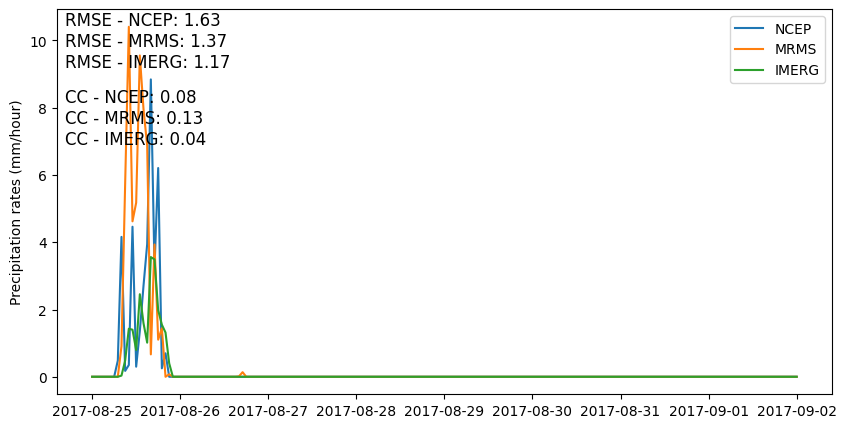

In [ ]:
fig= plt.figure(figsize=(10,5), facecolor='white')
ax= fig.add_subplot(111)
ax.plot(data_in['NCEP'], label='NCEP')
ax.plot(data_in['MRMS'], label='MRMS')
ax.plot(data_in['IMERG'], label='IMERG')
ax.legend()
ax.set_ylabel('Precipitation rates (mm/hour)')
ax.text(0.01, 0.85, f'RMSE - NCEP: {rmse[0]:.2f}\nRMSE - MRMS: {rmse[1]:.2f}\nRMSE - IMERG: {rmse[2]:.2f}', transform=ax.transAxes, fontsize=12)
ax.text(0.01, 0.65, f'CC - NCEP: {cc[0]:.2f}\nCC - MRMS: {cc[1]:.2f}\nCC - IMERG: {cc[2]:.2f}', transform=ax.transAxes, fontsize=12)
# fig.format(fontsize=(12))

We can also calculate TC metrics based on individual pixels and report the mean value and standard deviation for the whole region.

In [ ]:
rmse_ncep= []
rmse_mrms= []
rmse_imerg= []
cc_ncep= []
cc_mrms= []
cc_imerg= []
valid_coords= []

for subdf in tqdm(df.groupby(['lon', 'lat'])):
    # print(subdf)
    if len(subdf[1])>3:
        valid_coords.append(subdf[0])
        rmse, cc= mtc(subdf[1][['NCEP', 'MRMS', 'IMERG']])
        rmse_ncep.append(rmse[0])
        rmse_mrms.append(rmse[1])
        rmse_imerg.append(rmse[2])
        cc_ncep.append(cc[0])
        cc_mrms.append(cc[1])
        cc_imerg.append(cc[2])



100%|██████████| 5357/5357 [06:13<00:00, 14.34it/s]


In [ ]:
print(f'RMSE - NCEP: {np.nanmean(rmse_ncep):.2f} +/- {np.nanstd(rmse_ncep):.2f}')
print(f'RMSE - MRMS: {np.nanmean(rmse_mrms):.2f} +/- {np.nanstd(rmse_mrms):.2f}')
print(f'RMSE - IMERG: {np.nanmean(rmse_imerg):.2f} +/- {np.nanstd(rmse_imerg):.2f}')
print('--------------------------------------')
print(f'CC - NCEP: {np.nanmean(cc_ncep):.2f} +/- {np.nanstd(cc_ncep):.2f}')
print(f'CC - MRMS: {np.nanmean(cc_mrms):.2f} +/- {np.nanstd(cc_mrms):.2f}')
print(f'CC - IMERG: {np.nanmean(cc_imerg):.2f} +/- {np.nanstd(cc_imerg):.2f}')

RMSE - NCEP: 1.01 +/- 0.76
RMSE - MRMS: 1.23 +/- 0.91
RMSE - IMERG: 1.14 +/- 0.45
--------------------------------------
CC - NCEP: 0.67 +/- 0.28
CC - MRMS: 0.67 +/- 0.26
CC - IMERG: 0.43 +/- 0.24


Now we can also show the spatial error by transforming 1d array back to 2d.

In [ ]:
from shapely.geometry import box as Box
# Define the center coordinate.


# Create a GeoDataFrame with polygon geometry.
geometry = gpd.GeoDataFrame(
                            geometry=[Box(coord[0] + 0.05, coord[1] + 0.05,
                                          coord[0] - 0.05, coord[1] - 0.05) for coord in valid_coords])

# Populate the GeoDataFrame with RMSE and CC values.
geometry['rmse_ncep'] = rmse_ncep
geometry['rmse_mrms'] = rmse_mrms
geometry['rmse_imerg'] = rmse_imerg
geometry['cc_ncep'] = cc_ncep
geometry['cc_mrms'] = cc_mrms
geometry['cc_imerg'] = cc_imerg


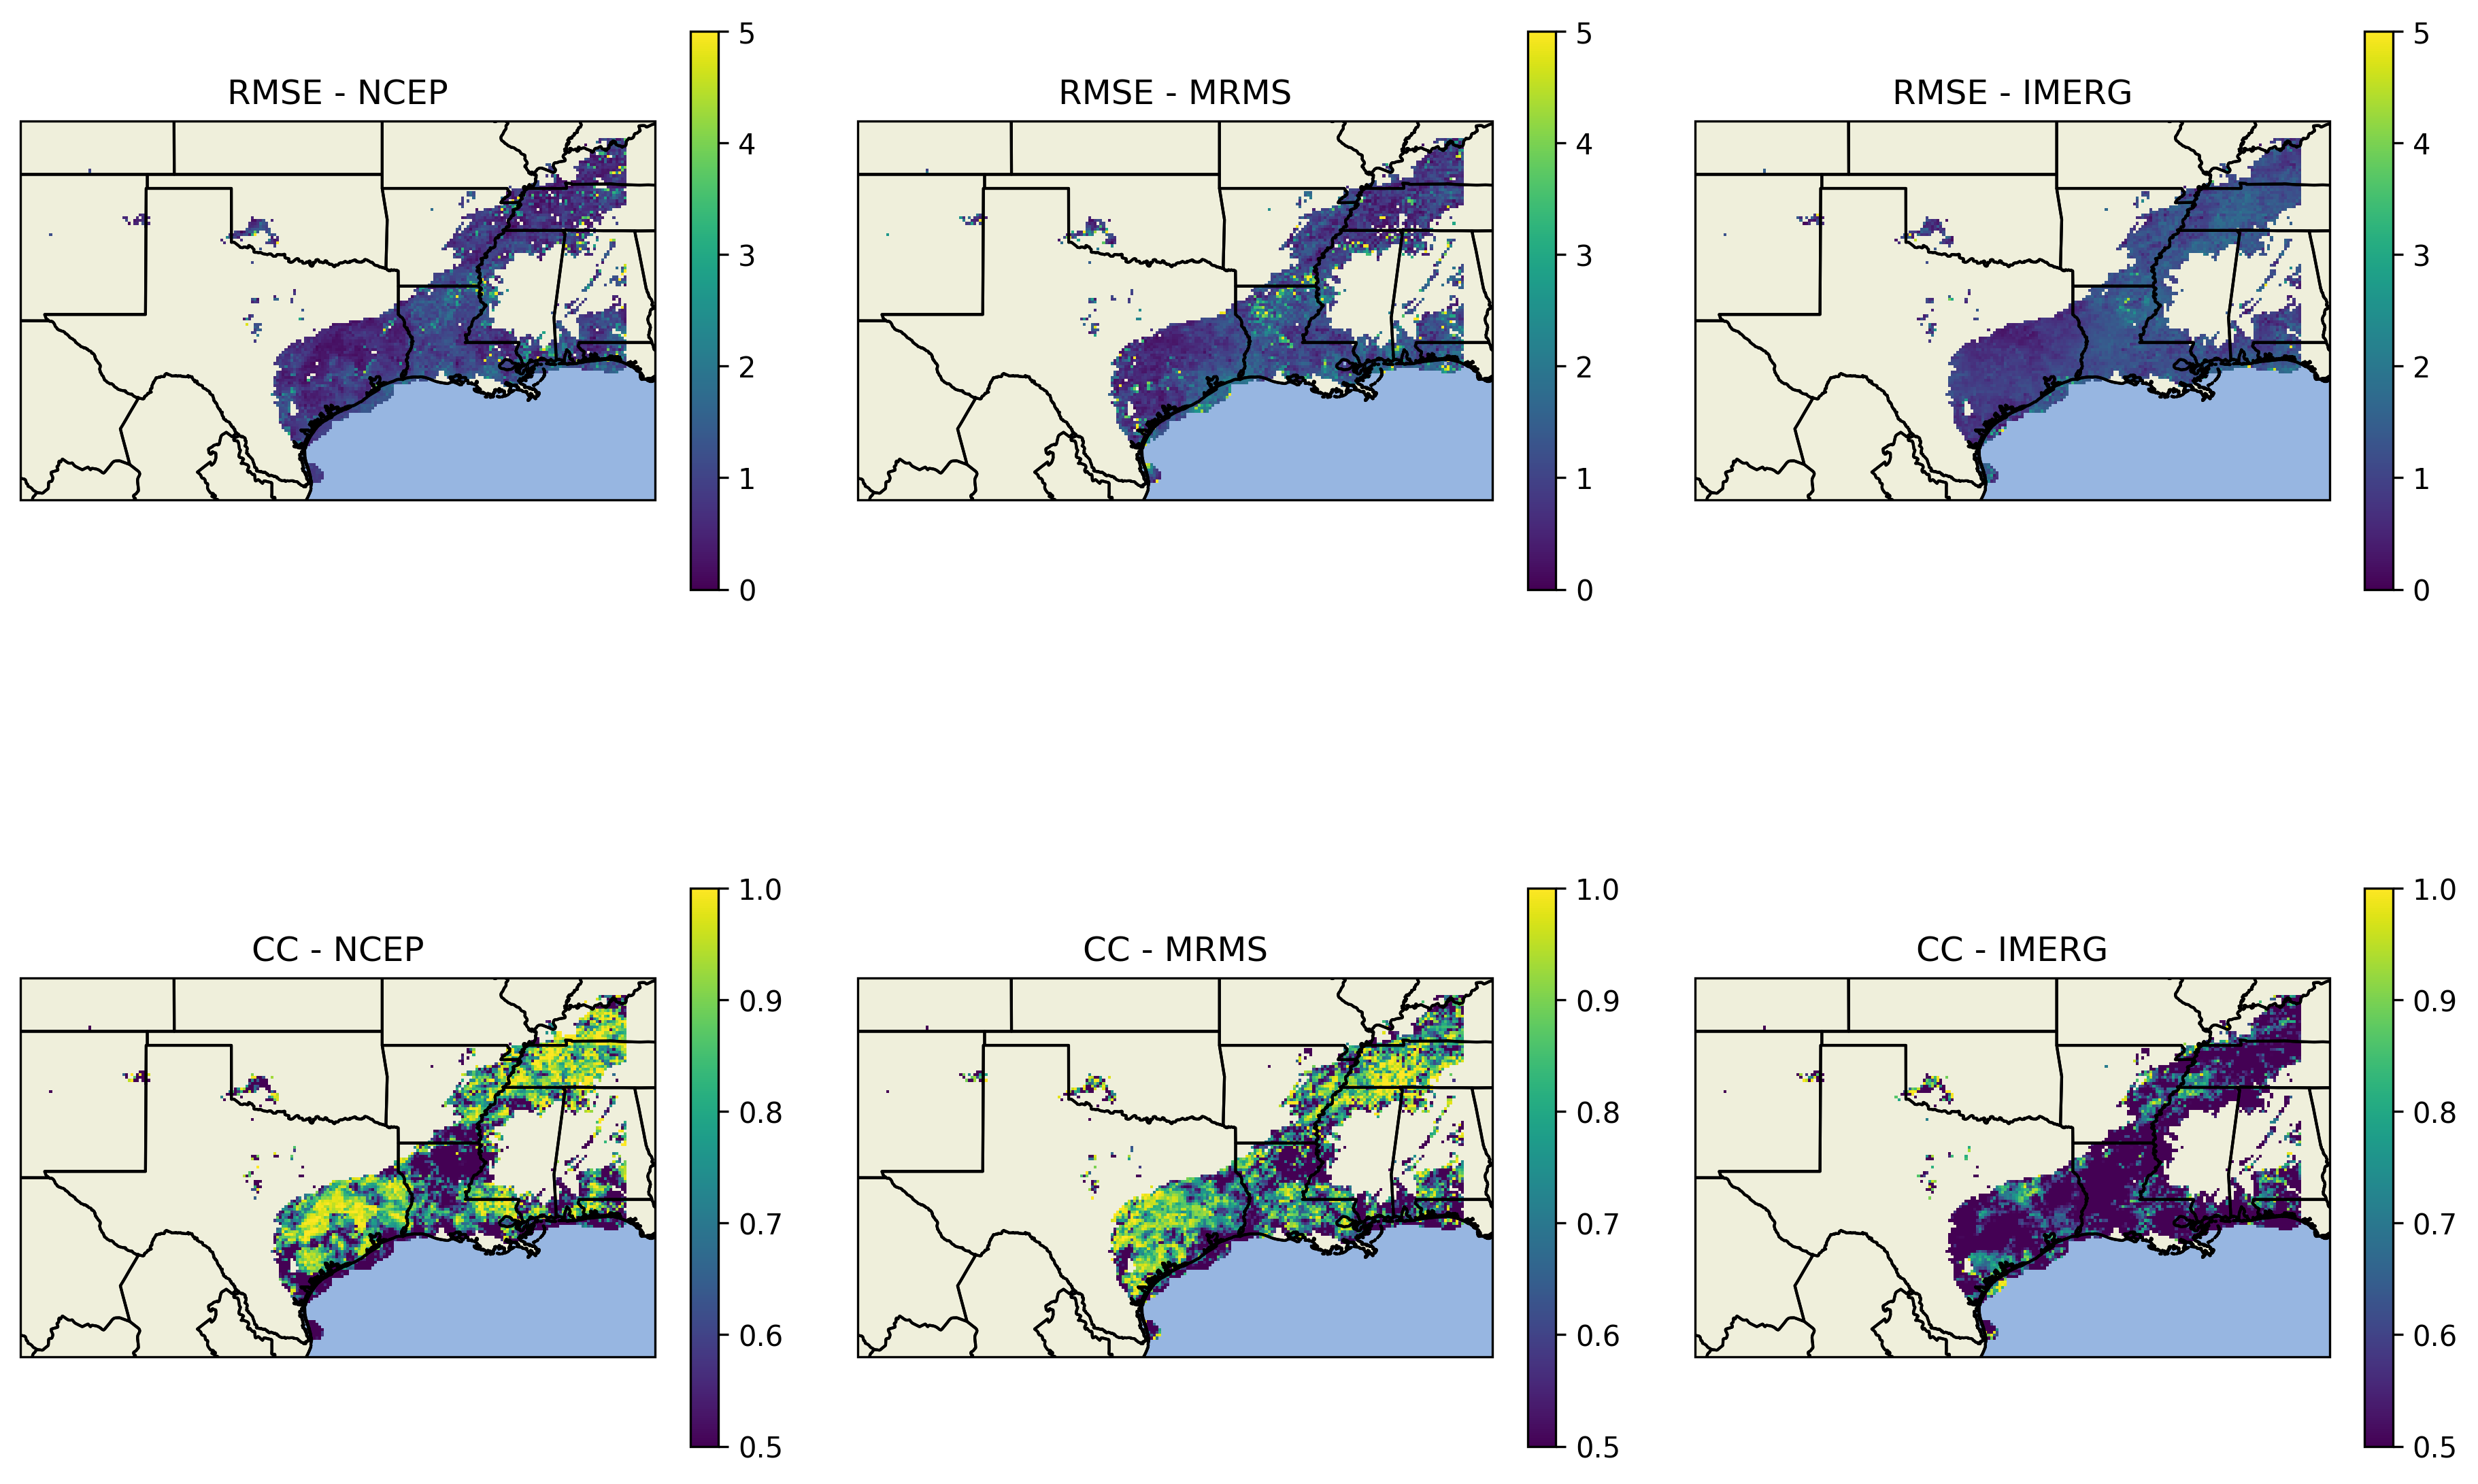

In [ ]:
# Plot the RMSE and CC values.
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()}, facecolor='white', dpi=300)
for ax in axes.flatten():
    ax.coastlines()
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.STATES)

for i, product in enumerate(['ncep', 'mrms', 'imerg']):
    geometry.plot(ax=axes[0, i], column=f'rmse_{product}', legend=True, vmin=0, vmax=5, legend_kwds={'fraction':0.04})
    axes[0, i].set_title(f'RMSE - {product.upper()}')

    geometry.plot(ax=axes[1, i], column=f'cc_{product}', legend=True, vmin=0.5, vmax=1, legend_kwds={'fraction':0.04})
    axes[1, i].set_title(f'CC - {product.upper()}')

plt.show()


# Reference

For your further reading, I have provided some research articles in this regard. Enjoy your food for thought!


McColl, K. A., Vogelzang, J., Konings, A. G., Entekhabi, D., Piles, M., & Stoffelen, A. (2014). Extended triple collocation: Estimating errors and correlation coefficients with respect to an unknown target. Geophysical research letters, 41(17), 6229-6236.


Li, Z., Chen, M., Gao, S., Hong, Z., Tang, G., Wen, Y., ... & Hong, Y. (2020). Cross-examination of similarity, difference and deficiency of gauge, radar and satellite precipitation measuring uncertainties for extreme events using conventional metrics and multiplicative triple collocation. Remote Sensing, 12(8), 1258.

Li, Z., Tang, G., Kirstetter, P., Gao, S., Li, J. L., Wen, Y., & Hong, Y. (2022). Evaluation of GPM IMERG and its constellations in extreme events over the conterminous united states. Journal of Hydrology, 606, 127357.

Wang, T., Li, Z., Ma, Z., Gao, Z., & Tang, G. (2023). Diverging identifications of extreme precipitation events from satellite observations and reanalysis products: A global perspective based on an object-tracking method. Remote Sensing of Environment, 288, 113490.

Li, Z., Wen, Y., Schreier, M., Behrangi, A., Hong, Y., & Lambrigtsen, B. (2021). Advancing satellite precipitation retrievals with data driven approaches: Is black box model explainable?. Earth and Space Science, 8(2), e2020EA001423.

Sun, Q., Miao, C., Duan, Q., Ashouri, H., Sorooshian, S., & Hsu, K.-L. (2018). A review of global precipitation data sets: Data sources, estimation, and intercomparisons. Reviews of Geophysics, 56, 79–107. https://doi.org/10.1002/2017RG000574

Tang, G., Clark, M. P., Papalexiou, S. M., Ma, Z., & Hong, Y. (2020). Have satellite precipitation products improved over last two decades? A comprehensive comparison of GPM IMERG with nine satellite and reanalysis datasets. Remote sensing of environment, 240, 111697.